# Validation of fitting uncertainty estimates using MC simulation

In [1]:
import fsl_mrs.utils.synthetic as syn
from copy import deepcopy

import numpy as np

## Create some reasonable noiselss data

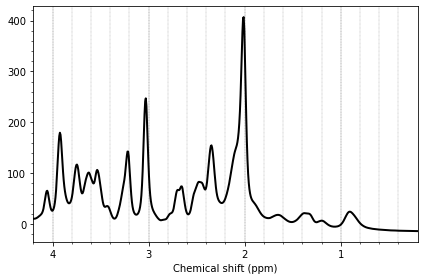

In [2]:
basis_file = '../testdata/fsl_mrs/steam_basis'
noiseless_fid, basemrs, trueconcs = syn.syntheticFromBasisFile(
    basis_file,
    ignore=['Ala', 'Asc', 'GSH', 'PE', 'Scyllo'],
    metab_groups=['Mac'],
    ind_scaling=['Mac',],
    concentrations={'Mac': 7},
    baseline=(-10,-10, 1, 1),
    baseline_ppm=(0.2, 4.2),
    broadening=[(20.0, 20.0), (0.0, 20.0)],
    noisecovariance=[[0.0]])


noiseless_mrs = deepcopy(basemrs)
noiseless_mrs.FID = noiseless_fid
noiseless_mrs.plot()

Define a function to add noise to a copy of the MRS object

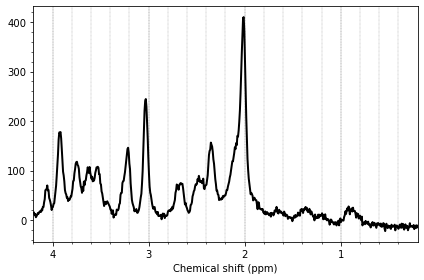

In [3]:
rng = np.random.default_rng()
def add_noise(level):
    noise = rng.standard_normal(noiseless_mrs.numPoints) * (level / np.sqrt(2))\
        + 1j * rng.standard_normal(noiseless_mrs.numPoints) * (level / np.sqrt(2))
    this_mrs = deepcopy(noiseless_mrs)
    this_mrs.FID = this_mrs.FID + noise
    return this_mrs

add_noise(5).plot()


## MC fitting stage

In [4]:
from fsl_mrs.utils.fitting import fit_FSLModel
from fsl_mrs.utils.misc import parse_metab_groups
from fsl_mrs.utils.plotting import plotly_fit


fitargs = {'baseline_order': 1,
           'metab_groups': parse_metab_groups(noiseless_mrs, ['Mac'])}

mc_reps = 500
est_std = []
est_mean = []
for idx in range(mc_reps):
    current_mrs = add_noise(5)

    res = fit_FSLModel(current_mrs, **fitargs)
    est_std.append(np.sqrt(res.crlb)[:-1])
    est_mean.append(res.params)


Double check that the residuals SD is what we expect (should return the noise value)

In [5]:
f,l = current_mrs.ppmlim_to_range((0.2, 4.2))
np.std(res.residuals[f:l])


4.944764713623822

## Assemble true values dataframe

In [6]:
import pandas as pd
true_values = trueconcs + [20.0, 0.0, 20.0, 20.0] + [0, 0,] + [0, 0,] + list((-10, -10, 1, 1))
true_df = pd.Series(true_values, index=res.params_names)

In [18]:
import pandas as pd

mean_values = pd.DataFrame(np.asarray(est_mean), columns=res.params_names_inc_comb, index=np.arange(mc_reps))
mean_values.drop('Cr+PCr', axis=1 ,inplace=True)
std_values = pd.DataFrame(np.asarray(est_std), columns=res.params_names, index=np.arange(mc_reps))

final_df = pd.concat(
    (true_df, mean_values.mean(), std_values.mean(), mean_values.std(), std_values.mean()/ mean_values.std() ),
    axis=1,
    keys=['true mean', 'est mean', 'est SD', 'mc SD', 'SD ratio'])
final_df

,true mean,est mean,est SD,mc SD,SD ratio
Asp,2.40,2.409617e+00,0.142264,0.146880,0.968575
Cr,4.87,4.863582e+00,0.187507,0.183523,1.021709
GABA,1.20,1.200966e+00,0.074887,0.075700,0.989250
GPC,0.74,7.344617e-01,0.067424,0.068003,0.991474
Glc,1.20,1.203229e+00,0.095331,0.092731,1.028041
Gln,3.37,3.368089e+00,0.087005,0.087275,0.996914
Glu,12.41,1.240401e+01,0.100582,0.102090,0.985230
Ins,7.72,7.727070e+00,0.068369,0.069329,0.986164
Lac,0.60,6.014551e-01,0.049516,0.050985,0.971196
Mac,7.00,7.058007e+00,0.198340,0.151893,1.305784


### View covariance

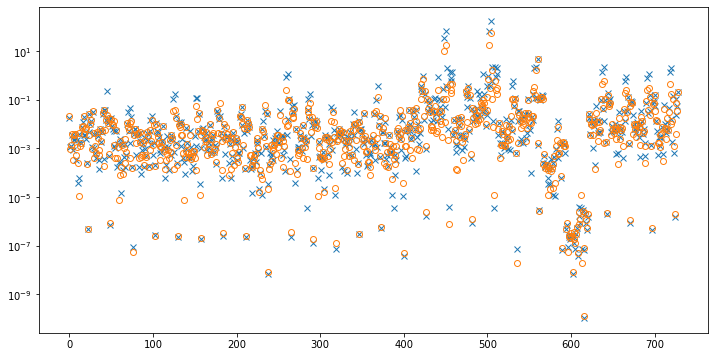

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
plt.semilogy(np.abs(res.cov.ravel()), 'x')
mc_cov = np.cov(np.asarray(est_mean)[:,:27].T)
plt.semilogy(np.abs(mc_cov.ravel()), 'o', markerfacecolor='none')
plt.show()

## MCMC evaluation  - WIP

In [ ]:
mc_reps = 100
est_std_mc = []
est_mean_mc = []
for idx in range(mc_reps):
    current_mrs = add_noise(15)

    res = fit_FSLModel(current_mrs, method='MH', **fitargs)
    est_std_mc.append(res.fitResults.std().values)
    est_mean_mc.append(res.params)


In [ ]:
mean_values_mc = pd.DataFrame(np.asarray(est_mean_mc), columns=res.params_names, index=np.arange(mc_reps))
std_values_mc = pd.DataFrame(np.asarray(est_std_mc), columns=res.params_names_inc_comb, index=np.arange(mc_reps))

final_df_mc = pd.concat(
    (mean_values_mc.mean(), std_values_mc.mean(), mean_values_mc.std(),std_values_mc.mean()/mean_values_mc.std()),
    axis=1,
    keys=['est mean', 'est SD', 'mc SD', 'SD ratio'])
final_df_mc